# [route-direction viz wrangling](https://github.com/orgs/cal-itp/projects/30/views/1?pane=issue&itemId=105612776)


In [1]:
import _report_utils
import altair as alt
import merge_data
import numpy as np
import pandas as pd
import yaml
from segment_speed_utils import gtfs_schedule_wrangling, helpers, time_series_utils
from segment_speed_utils.project_vars import COMPILED_CACHED_VIEWS, PROJECT_CRS
from shared_utils import (
    catalog_utils,
    dask_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
analysis_date_list = rt_dates.y2024_dates

In [4]:
FILE = GTFS_DATA_DICT.schedule_tables.gtfs_key_crosswalk

crosswalk_cols = [
    "schedule_gtfs_dataset_key",
    "name",
    "organization_name",
]

df = time_series_utils.concatenate_datasets_across_dates(
    SCHED_GCS, FILE, analysis_date_list, data_type="df", columns=crosswalk_cols
).drop_duplicates()

## Scratch Work
* This operator has multiple organization_names. 
* This is not correct, we want to keep only one. 
* Which one is the right one to select?
* By mapping Foothill Schedule originally, we are merely going back to name. 

In [5]:
df.loc[df.name.str.contains("Foothill")]

,schedule_gtfs_dataset_key,name,organization_name,service_date
99,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,City of Duarte,2024-02-14
100,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit,2024-02-14
97,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,City of Duarte,2024-03-13
98,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit,2024-03-13
100,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,City of Duarte,2024-04-17
101,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit,2024-04-17
97,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,City of Duarte,2024-05-22
98,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit,2024-05-22
90,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,City of Duarte,2024-06-12
91,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit,2024-06-12


In [6]:
with open("../_shared_utils/shared_utils/portfolio_organization_name.yml", "r") as f:
    PORTFOLIO_ORGANIZATIONS_DICT = yaml.safe_load(f)

In [7]:
df2 = df.pipe(
    portfolio_utils.standardize_portfolio_organization_names,
    PORTFOLIO_ORGANIZATIONS_DICT,
)

* This step is not done. Don't move onto the deploying this. 
* Two rows for every service date. How do we deal with this?
* This will cause Foothll Transit to appear twice because City of Duarte and Foothill Transit. 
* Add all the columns I'm creating in the same place.
* Write a function that aggregates this to portfolio_organization_name and service_date to deal with this duplicate
* Use City and County of SF and Foothill Transit. 
* Probably need to drop some rows, combine some rows. 
* Don't create all new columns in the chart making step. 
* Create data after we get to the `portfolio_organization_name`
* This is the only grain I'll be visualizing. 
* I should only have 4 datasets and they should all be by `portfolio_organization_name`
* When I'm building quarterly stuff, I am adding even more rows. 
* Charts should only use 4 datasets at the new grain using the `portfolio_organization_name`
* `organization_name` needs to be dropped eventually. 
* I might still have `name` but not sure. 
* We don't need `schedule_gtfs_Dataset_key` and we don't need `name`.
* Look at Evan's list, but look at my other list with LA Metro which includes LA Bus/Rail.
    * Check everything.
* City of Duarte and Foothill have the same info so we can delete
* We only need schd key, name, service_date, portfolio_org_name & de duplicate 

In [8]:
# df2.loc[df2.name.str.contains("Foothill")]

In [9]:
df2.loc[df2.name.str.contains("Foothill")].columns

Index(['schedule_gtfs_dataset_key', 'name', 'organization_name',
       'service_date', 'portfolio_organization_name'],
      dtype='object')

* De duplicating on `key`, `name`, and `portfolio_organization_name`
* I can get it to one row but then I would have to check if `route_name-direction` are unique to the portfolio_organization_name
* What if Basin Transit GMV and Morongo Basin use both Route ID 1? Don't mix them up if they are using the same route ID name.
* These are different feeds so there is no gurantee that they have to pick uniqe route IDS
* If route IDS aren't unique, then we have to leave it as 2 rows 
* Just leave it as two rows since this will fix both the top and bottom examples, but this means I will have to unpack any route IDs that are repated across different `schedule_gtfs_dataset_keys`

In [10]:
"""df2.loc[df2.organization_name.str.contains("Basin")].sort_values(
    by=["portfolio_organization_name", "service_date"]
)"""

'df2.loc[df2.organization_name.str.contains("Basin")].sort_values(\n    by=["portfolio_organization_name", "service_date"]\n)'

## Function 1 for Bullet Point (2): time-series operator route-direction data becomes portfolio_organization route-direction data

In [11]:
DIGEST_RT_SCHED = GTFS_DATA_DICT.digest_tables.route_schedule_vp

In [12]:
schd_vp_df = pd.read_parquet(f"{RT_SCHED_GCS}{DIGEST_RT_SCHED}.parquet")

In [19]:
def portfolio_organization_name_grain(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input df after merge_data_sources_by_route_direction().
    Change grain from "schedule_gtfs_dataset_key", "name", "organization_name" to
    "portfolio_organization_name". Do some light cleaning.
    """
    # Drop duplicates for these following rows
    df2 = df.drop_duplicates(
        subset=[
            "schedule_gtfs_dataset_key",
            "organization_name",
            "service_date",
            "portfolio_organization_name",
            "route_id",
        ]
    )

    return df2

In [42]:
# Test it out
function1_test = portfolio_organization_name_grain(schd_vp_df)

In [39]:
len(function1_test), len(schd_vp_df)

(78179, 708563)

In [44]:
function1_test.columns

Index(['schedule_gtfs_dataset_key', 'route_id', 'direction_id', 'time_period',
       'avg_scheduled_service_minutes', 'avg_stop_miles', 'n_scheduled_trips',
       'frequency', 'service_date', 'is_express', 'is_ferry', 'is_rail',
       'is_coverage', 'is_local', 'is_downtown_local', 'is_rapid', 'typology',
       'name', 'combined_name', 'recent_combined_name', 'recent_route_id',
       'route_primary_direction', 'minutes_atleast1_vp', 'minutes_atleast2_vp',
       'total_rt_service_minutes', 'total_scheduled_service_minutes',
       'total_vp', 'vp_in_shape', 'is_early', 'is_ontime', 'is_late',
       'n_vp_trips', 'vp_per_minute', 'pct_in_shape',
       'pct_rt_journey_atleast1_vp', 'pct_rt_journey_atleast2_vp',
       'pct_sched_journey_atleast1_vp', 'pct_sched_journey_atleast2_vp',
       'rt_sched_journey_ratio', 'avg_rt_service_minutes', 'sched_rt_category',
       'speed_mph', 'schedule_source_record_id', 'base64_url',
       'organization_source_record_id', 'organization_name

In [22]:
function1_test.portfolio_organization_name = (
    function1_test.portfolio_organization_name.fillna("None")
)

/tmp/ipykernel_458/4047423999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function1_test.portfolio_organization_name = (


In [23]:
def check_results(df: pd.DataFrame, operator: str) -> pd.DataFrame:
    df2 = df.loc[df.portfolio_organization_name.str.contains(operator)]

    agg1 = df2.groupby(["service_date", "name"]).agg({"route_id": "nunique"})

    display(agg1)
    df3 = (
        df2[
            [
                "service_date",
                "schedule_gtfs_dataset_key",
                "name",
                "portfolio_organization_name",
            ]
        ]
        .drop_duplicates()
        .sort_values(
            by=[
                "service_date",
                "name",
            ]
        )
    )
    display(df3)

In [24]:
check_results(function1_test, "City and County of San Francisco")

,,route_id
service_date,name,
2023-03-15,Bay Area 511 Muni Schedule,67
2023-04-12,Bay Area 511 Muni Schedule,67
2023-05-17,Bay Area 511 Muni Schedule,67
2023-06-14,Bay Area 511 Muni Schedule,67
2023-07-12,Bay Area 511 Muni Schedule,67
2023-08-15,Bay Area 511 Muni Schedule,67
2023-10-11,Bay Area 511 Muni Schedule,68
2023-11-15,Bay Area 511 Muni Schedule,70
2023-12-13,Bay Area 511 Muni Schedule,68


,service_date,schedule_gtfs_dataset_key,name,portfolio_organization_name
630799,2023-03-15,d8453d9a4ae1184f7e1339f7c61849df,Bay Area 511 Muni Schedule,City and County of San Francisco
417020,2023-04-12,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417021,2023-05-17,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417022,2023-06-14,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417023,2023-07-12,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417024,2023-08-15,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417025,2023-10-11,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417026,2023-11-15,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417027,2023-12-13,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco
417028,2024-01-17,7cc0cb1871dfd558f11a2885c145d144,Bay Area 511 Muni Schedule,City and County of San Francisco


In [25]:
check_results(function1_test, "Foothill Transit")

,,route_id
service_date,name,
2023-03-15,Foothill Schedule,38
2023-04-12,Foothill Schedule,38
2023-05-17,Foothill Schedule,38
2023-06-14,Foothill Schedule,38
2023-07-12,Foothill Schedule,38
2023-08-15,Foothill Schedule,36
2023-09-13,Foothill Schedule,36
2023-10-11,Foothill Schedule,36
2023-11-15,Foothill Schedule,35


,service_date,schedule_gtfs_dataset_key,name,portfolio_organization_name
673154,2023-03-15,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673158,2023-04-12,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673162,2023-05-17,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673166,2023-06-14,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673168,2023-07-12,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673170,2023-08-15,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673174,2023-09-13,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673178,2023-10-11,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673182,2023-11-15,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit
673186,2023-12-13,f74424acf8c41e4c1e9fd42838c4875c,Foothill Schedule,Foothill Transit


In [26]:
check_results(function1_test, "Basin Transit")

,,route_id
service_date,name,
2023-11-15,Morongo Basin Schedule,7
2023-12-13,Morongo Basin Schedule,7
2024-01-17,Morongo Basin Schedule,7
2024-02-14,Morongo Basin Schedule,7
2024-03-13,Morongo Basin Schedule,7
2024-04-17,Morongo Basin Schedule,7
2024-05-22,Morongo Basin Schedule,7
2024-06-12,Morongo Basin Schedule,7
2024-07-17,Morongo Basin Schedule,7


,service_date,schedule_gtfs_dataset_key,name,portfolio_organization_name
491279,2023-11-15,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491280,2023-12-13,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491281,2024-01-17,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491282,2024-02-14,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491283,2024-03-13,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491284,2024-04-17,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491285,2024-05-22,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491286,2024-06-12,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491287,2024-07-17,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit
491288,2024-08-14,b0760015c9fcd0500c4fddd5b9bb115b,Morongo Basin Schedule,Basin Transit


In [27]:
function1_test.loc[
    (function1_test.name == "Morongo Basin Schedule")
    & (function1_test.service_date == "2025-03-12")
].route_id.unique()

array(['344', '346', '347', '348', '349', '350', '351'], dtype=object)

In [28]:
function1_test.loc[
    (function1_test.name == "Basin Transit GMV Schedule")
    & (function1_test.service_date == "2025-03-12")
].route_id.unique()

array(['6588', '6589', '6590', '6591', '6594', '6595', '6596'],
      dtype=object)

## Function 2 for Bullet Point (3): data wrangling for visualizations - create columns, replace values, rename columns
* What's the difference between `recent_route_id` vs. `route_id` and `recent_combined_name` vs. `combined_name`
* <i>when you already have a list of columns defined, write this way instead of a loop: df[pct_cols] =df[pct_cols]*100</i> AH: I get an error when I do it this way.
* <i>in the data cleaning step, specifically define what are the columns that you need to keep, and only keep those. there looks to be several columns that are unused anyway, so don't keep those, and it will make clear what columns need to be renamed / aggregated.</i>

In [61]:
readable_col_names = {
    "direction_id": "Direction (0/1)",
    "time_period": "Period",
    "avg_scheduled_service_minutes": "Average Scheduled Service (trip minutes)",
    "n_scheduled_trips": "# scheduled trips",
    "service_date": "Date",
    "recent_combined_name": "Route",
    "route_primary_direction": "Direction",
    "minutes_atleast1_vp": "# Minutes with 1+ VP per Minute",
    "minutes_atleast2_vp": "# Minutes with 2+ VP per Minute",
    "is_early": "# Early Arrival Trips",
    "is_ontime": "# On-Time Trips",
    "is_late": "# Late Trips",
    "vp_per_minute": "Average VP per Minute",
    "pct_in_shape": "% VP within Scheduled Shape",
    "pct_sched_journey_atleast1_vp": "% Scheduled Trip w/ 1+ VP/Minute",
    "pct_sched_journey_atleast2_vp": "% Scheduled Trip w/ 2+ VP/Minute",
    "rt_sched_journey_ratio": "Realtime versus Scheduled Service Ratio",
    "speed_mph": "Speed (MPH)",
    "portfolio_organization_name": "Portfolio Organization Name",
    "headway_in_minutes": "Headway (Minutes)",
}

In [58]:
# Lifted from my `report_operator_section2_utils`
def data_wrangling_for_visualizing(df: pd.DataFrame) -> pd.DataFrame:

    # Round float columns
    float_columns = df.select_dtypes(include=["float"])
    for i in float_columns:
        df[i] = df[i].round(2)

    # Multiply percent columns to 100%
    pct_cols = df.columns[df.columns.str.contains("pct")].tolist()
    for i in pct_cols:
        df[i] = df[i] * 100

    # Create the new column here?
    df["headway_in_minutes"] = 60 / df.frequency

    # Keep only schedule and vp
    df2 = df.loc[df.sched_rt_category == "schedule_and_vp"].reset_index(drop=True)
    # Subset to only relevant columns
    subset = [
        "direction_id",
        "time_period",
        "avg_scheduled_service_minutes",
        "n_scheduled_trips",
        "service_date",
        "recent_combined_name",
        "route_primary_direction",
        "minutes_atleast1_vp",
        "minutes_atleast2_vp",
        "is_early",
        "is_ontime",
        "is_late",
        "vp_per_minute",
        "pct_in_shape",
        "pct_sched_journey_atleast1_vp",
        "pct_sched_journey_atleast2_vp",
        "rt_sched_journey_ratio",
        "speed_mph",
        "portfolio_organization_name",
        "headway_in_minutes",
    ]

    # Subset
    df2 = df2[subset]

    # Replace column names
    df2.columns = df2.columns.map(readable_col_names)

    return df2

In [59]:
function2_test = data_wrangling_for_visualizing(function1_test)

/tmp/ipykernel_458/4231835574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].round(2)
/tmp/ipykernel_458/4231835574.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i] * 100
/tmp/ipykernel_458/4231835574.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [60]:
function2_test.columns

Index(['dir_0_1', 'Period', 'Average Scheduled Service (trip minutes)',
       '# scheduled trips', 'Date', 'Route', 'Direction',
       '# Minutes with 1+ VP per Minute', '# Minutes with 2+ VP per Minute',
       '# Early Arrival Trips', '# On-Time Trips', '# Late Trips',
       'Average VP per Minute', '% VP within Scheduled Shape',
       '% Scheduled Trip w/ 1+ VP/Minute', '% Scheduled Trip w/ 2+ VP/Minute',
       'Realtime versus Scheduled Service Ratio', 'Speed (MPH)',
       'Portfolio Organization Name', 'Headway (Minutes)'],
      dtype='object')

In [ ]:
function2_test.sample(3)

## (4) route dropdown to visualize time-series trends
Route dropdown chart (TODO)

    TODO: Below is pseudo code to get you started.
        6-7 chart type functions
        2 chart config functions
        8 functions for each metric listed below created in the route dropdown
        1 wrapper function of the 8 functions

Charts in this section:

    avg scheduled service
    timeliness by direction
    frequency / headway
    avg speed by direction
    vp per minute
    % scheduled journey with vp
    spatial accuracy
    text of other metrics by direction


### Config functions: #1

In [ ]:
def set_y_axis(df, y_col):
    """
    Set y_axis automatically depending on the
    column used to generate the y_axis.
    """
    if "%" in y_col:
        max_y = 100
    elif "VP" in y_col:
        max_y = 3
    elif "Minute" in y_col:
        max_y = round(df[y_col].max())
    else:
        max_y = round(df[y_col].max(), -1) + 5
    return max_y

In [ ]:
def configure_chart(
    chart: alt.Chart, width: int, height: int, title: str, subtitle: str
) -> alt.Chart:
    """
    Adjust width, height, title, and subtitle
    """
    chart2 = chart.properties(
        width=width,
        height=height,
        title={
            "text": [title],
            "subtitle": [subtitle],
        },
    )
    return chart2

### Chart 1: Ruler Chart
<i>the ruler value doesn't depend on groups within the df, so there's no need to inject it as a column value, since the value is the same throughout. if the ruler value differed for each operator, then this value should be programmatically added in the data cleaning step.</i> I tried to inject just 100 into the `.encode(y=f"{ruler_value}:Q")` without adding it as a new column in the dataframe. However, the graph doesn't show the red dotted line I would like. 

In [ ]:
def ruler_chart(df: pd.DataFrame, ruler_value: int) -> pd.DataFrame:
    # Add the ruler column

    df["ruler"] = ruler_value
    chart = (
        alt.Chart(df)
        .mark_rule(color="red", strokeDash=[10, 7])
        .encode(y=f"mean(ruler):Q")
    )
    return chart

In [ ]:
ruler_chart(function2_test.head(2), 100)

### Other Feedback 4/15/25
#### Setting `Y-Axis`
* I think this is necessary if we want uniformity across our charts. Otherwise, the y-axis is going to change with each route. Many charts are all set to a manual value, rather than `df[y_col].max()`
* Spatial Accuracy = maximum is 100
* Vehicle Positions per Minute = maximum is 3
* Frequency of Trips = maximum (at least what we show) is 250
* Breakdown of Trips by Timeliness = maximum is 100
* % of Scheduled Trip with 1/2 VP = maximum is 100 
* Total Scheduled Trips by Period = 
#### `Color Argument`
<i>color seems to be an iffy one to include as an argument...it can be added on this way for now to get a better sense, it makes sense to define color palettes, and having the colors be defined in readable v2 will allow it to be used here. what's the mix of charts that need color palettes defined vs not?</i>
* Yes this is necessary because almost every metric requires its own color palette. 
* Spatial Accuracy = I specifically picked colors that go from green (100%) and pink/red (0%)
* Vehicle Positions = Same thing. 
* Frequency of Trips in Minutes = I picked colors that go from green (low headways) to red (high headways). This isn't on the 0-100 percentage scale, so I created another color palette.
* Total Scheduled Trips by Period = Picked a simple color palette.

### Actions taken
* Removed `_report_utils.labeling()`

### Chart 2: Pie
* Used only 1x for Total Routes by Typology. 

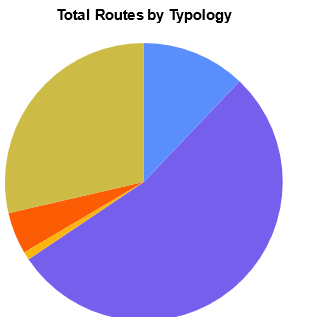

In [ ]:
def basic_pie_chart(df: pd.DataFrame, color_col: str, theta_col: str) -> alt.Chart:
    chart = (
        alt.Chart(df)
        .mark_arc()
        .encode(
            theta=theta_col,
            color=alt.Color(
                color_col,
                title=(color_col),
                scale=alt.Scale(range=color_dict["full_color_scale"]),
            ),
            tooltip=df.columns.tolist(),
        )
    )

    return chart

### Chart 3: Bar
* Used for 
* Comparing longest and shortest route.
* Metrics for all routes (plus a ruler)
* Spatial Accuracy (plus a ruler)
* Frequency of Trips 

In [ ]:
def bar_chart(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    color_col: str,
    color_scheme: list,
) -> alt.Chart:

    # Set y-axis
    max_y = set_y_axis(df, y_col)

    chart = (
        alt.Chart(df)
        .mark_bar()
        .encode(
            x=alt.X(
                x_col,
                title=(x_col),
                axis=alt.Axis(labelAngle=-45),
                scale=alt.Scale(domain=[0, max_y]),
            ),
            y=alt.Y(y_col, title=y_col),
            color=alt.Color(
                color_col,
                legend=None,
                title=(color_col),
                scale=alt.Scale(
                    range=color_scheme,
                ),
            ),
            tooltip=list(df.columns),
        )
    )

    return chart

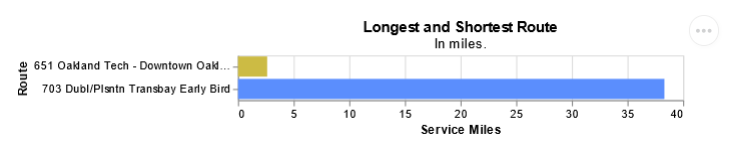

In [ ]:
def longest_shortest_route_chart(gdf: pd.DataFrame) -> alt.Chart:
    gdf2 = shortest_longest_route(gdf)
    chart = bar_chart(
        df=gdf2,
        x_col="Service Miles",
        y_col="Route",
        color_col="Route",
        color_scheme=["TBD"],
    )

    chart = configure_chart(
        chart, width=400, height=250, title="title", subtitle="subtitle"
    )
    return chart

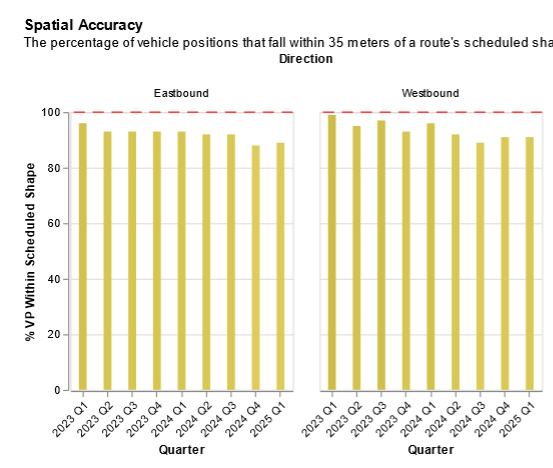

In [ ]:
def spatial_accuracy_chart(df: pd.DataFrame) -> alt.Chart:

    # Create ruler chart
    ruler_chart = create_ruler_chart(df, "spatial accuracy ruler")

    # Create Base Chart
    base_chart = bar_chart(
        df=df,
        x_col="Quarter",
        y_col="% VP within Scheduled Shape",
        color_col="% VP within Scheduled Shape",
        color_scheme=["TBD"],
    )

    # Combine
    chart = ruler_chart + base_chart
    # Facet
    chart = chart.facet(
        column=alt.Column(
            "Direction:N",
        )
    )

    # Adjust height/width
    chart = configure_chart(
        chart, width=400, height=250, title="title", subtitle="subtitle"
    )

    return chart

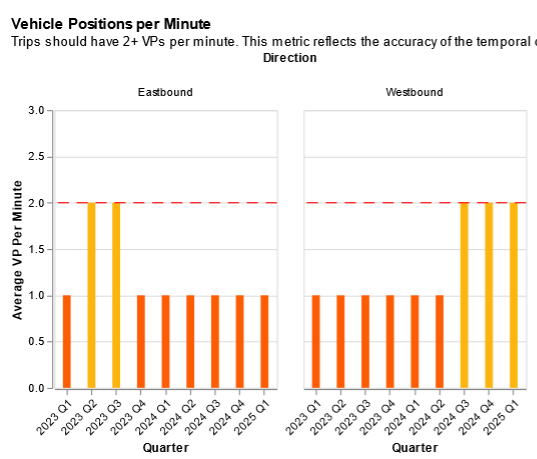

In [ ]:
def vp_per_minute_chart(df: pd.DataFrame) -> alt.Chart:
    ruler_chart = ruler_chart(df, "vp_per_minute")
    base_chart = bar_chart(
        df=df,
        x_col="Quarter",
        y_col="% VP within Scheduled Shape",
        color_col="% VP within Scheduled Shape",
        color_scheme=["TBD"],
    )

    # Combine
    chart = ruler_chart + base_chart
    # Facet
    chart = chart.facet(
        column=alt.Column(
            "Direction:N",
        )
    )
    chart = configure_chart(
        chart, width=400, height=250, title="title", subtitle="subtitle"
    )

    return chart

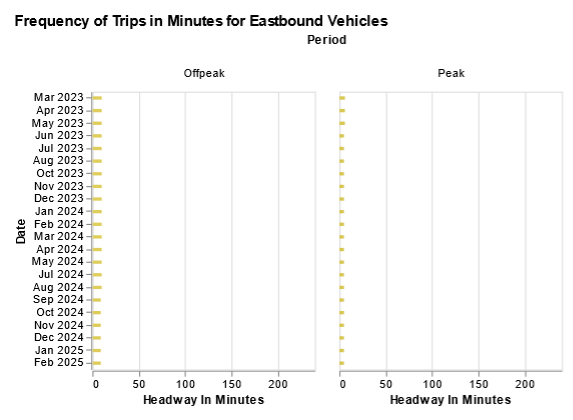

In [ ]:
def headway_chart(df: pd.DataFrame) -> alt.Chart:
    base_chart = bar_chart(
        df=df,
        x_col="headway_in_minutes",
        y_col="Date",
        color_col="headway_in_minutes",
        color_scheme=["TBD"],
    )

    # Facet
    base_chart = base_chart.facet(
        column=alt.Column(
            "Period:N",
        )
    )

    base_chart = configure_chart(
        base_chart, width=400, height=250, title="title", subtitle="subtitle"
    )

    return base_chart

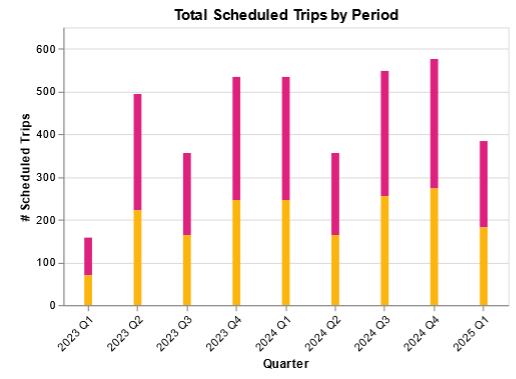
* Made stacked simply by setting the `color_col` column to `Period` 

In [ ]:
def total_scheduled_trips_chart(df: pd.DataFrame) -> alt.Chart:
    base_chart = bar_chart(
        df=df,
        x_col="# scheduled trips",
        y_col="Date",
        color_col="Period",
        color_scheme=["TBD"],
    )

    base_chart = configure_chart(
        base_chart, width=400, height=250, title="title", subtitle="subtitle"
    )

    return base_chart

### Chart 4: Line

In [ ]:
def line_chart(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    color_col: str,
    color_scheme: list,
):
    # Set y-axis
    max_y = set_y_axis(df, y_col)

    # Set chart
    chart = (
        alt.Chart(df)
        .mark_line(size=3)
        .encode(
            x=alt.X(
                x_col,
                title=x_col,
                axis=alt.Axis(labelAngle=-45),
            ),
            y=alt.Y(
                f"{y_col}:Q",
                title=y_col,
                scale=alt.Scale(domain=[0, max_y]),
            ),
            color=alt.Color(
                f"{color_col}:N",
                title=color_col,
                scale=alt.Scale(range=color_scheme),
            ),
            tooltip=list(df.columns),
        )
    )
    return chart

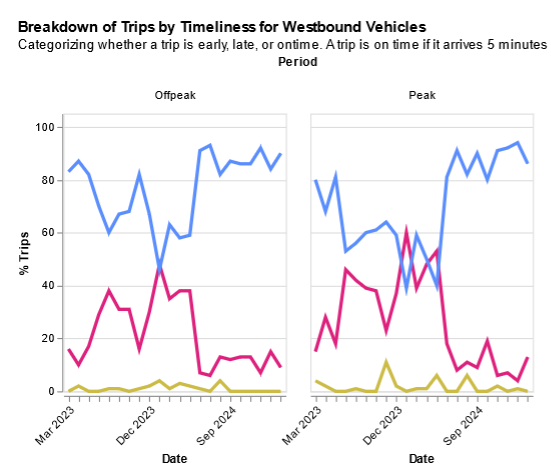

In [ ]:
def timeliness_chart(df) -> alt.Chart:
    base_chart = line_chart(
        df=df,
        x_col=x_col,
        y_col=y_col,
        title="title",
        subtitle="subtitle",
        color_scheme=["color"],
    )

    # Set title/width
    base_chart = configure_chart(
        base_chart, width=200, height=250, title="title", subtitle="subtitle"
    )

    # Facet
    base_chart = base_chart.facet(
        column=alt.Column(
            "Period:N",
        )
    )
    return base_chart

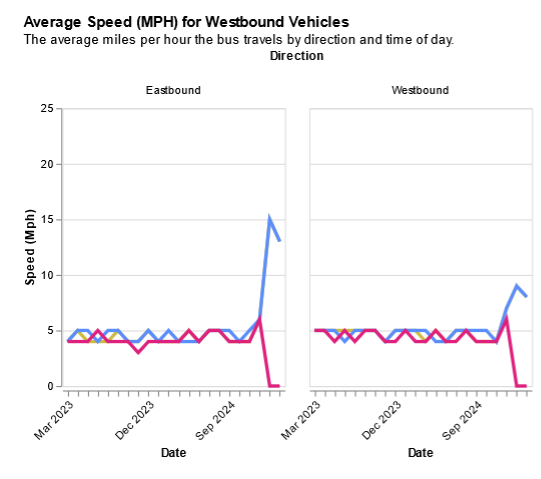

In [ ]:
def speed_chart(df) -> alt.Chart:
    base_chart = line_chart(
        df=df,
        x_col=x_col,
        y_col=y_col,
        title="title",
        subtitle="subtitle",
        color_scheme=["color"],
    )

    # Set title/width
    base_chart = configure_chart(
        base_chart, width=200, height=250, title="title", subtitle="subtitle"
    )

    # Facet
    base_chart = base_chart.facet(
        column=alt.Column(
            "Direction:N",
        )
    )
    return base_chart

### Chart 5: Divider

In [ ]:
def divider_chart(df: pd.DataFrame, title: str):
    """
    This chart creates only one line of text.
    I use this to divide charts thematically.
    """
    df = df.head(1)
    # Create a text chart using Altair
    chart = (
        alt.Chart(df)
        .mark_text(
            align="center",
            baseline="middle",
            fontSize=14,
            fontWeight="bold",
            text=title,
        )
        .properties(width=400, height=100)
    )

    return chart

### Chart 6: Text

In [ ]:
def reshape_df_text_table(df: pd.DataFrame) -> pd.DataFrame:
    # Reshape dataframe before plotting
    df2 = df.melt(
        id_vars=[
            "Route",
            "Direction",
        ],
        value_vars=[
            "Average Scheduled Service (Trip Minutes)",
            "Average Stop Distance (Miles)",
            "# Scheduled Trips",
            "Peak Avg Speed",
            "Peak Scheduled Trips",
            "Peak Hourly Freq",
            "Offpeak Avg Speed",
            "Offpeak Scheduled Trips",
            "Trips Per Hour",
        ],
    )

    # Create a decoy column so all the text will be centered.
    df2["Zero"] = 0

    # Combine columns so the column title and variable will be aligned.
    # Ex: "Trips Per Hour: 0.56". This column is what will show up on the
    # graphs.
    df2["combo_col"] = df2.variable.astype(str) + ": " + df2.value.astype(str)

    # Clean up
    df2.combo_col = df2.combo_col.str.replace(
        "schedule_and_vp",
        "Schedule and Realtime Data",
    ).str.replace("Gtfs", "GTFS")

    return df2

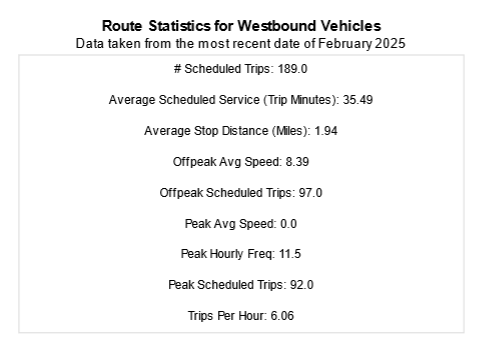

In [ ]:
def text_table(df: pd.DataFrame, direction: int) -> alt.Chart:

    # Filter dataframe for direction
    df = df.loc[df["Dir 0 1"] == direction].drop_duplicates().reset_index(drop=True)

    # Grab variables to use for title/subtitle
    direction = df.Direction.iloc[0]
    most_recent_date = df.Date.iloc[0].strftime("%B %Y")

    # Melt so the dataframe can be plotted
    df2 = reshape_df_text_table(df)

    # Create the chart
    text_chart = (
        alt.Chart(df2)
        .mark_text()
        .encode(x=alt.X("Zero:Q", axis=None), y=alt.Y("combo_col", axis=None))
    )

    text_chart = text_chart.encode(text="combo_col:N")

    # Configure this
    text_chart = configure_chart(
        text_chart,
        width=400,
        height=250,
        title=title,
        subtitle=subtitle,
    )

    return text_chart

### Chart 7: Grouped Bar Chart


In [ ]:
def grouped_bar(
    df: pd.DataFrame, x_col: str, y_col: str, offset_col: str, color_col: str
) -> alt.Chart:
    chart = bar_chart(
        df=pd.DataFrame,
        x_col=str,
        y_col=str,
        offset_col=str,
        color_col=str,
        color_scheme=list,
    )
    # Add Offset
    chart2 = chart.mark_bar(size=5).encode(
        xOffset=alt.X(offset_col, title=offset_col),
    )
    return chart

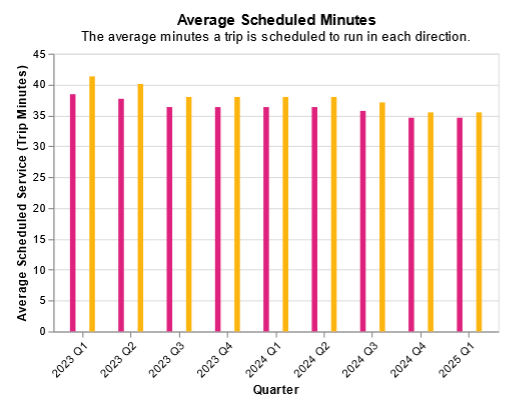

In [ ]:
def avg_scheduled_minutes_chart(df: pd.DataFrame) -> alt.Chart:
    chart = create_grouped_bar(df, x_col, y_col, offset_col, color_col)
    # Configure this
    chart = configure_chart(
        chart,
        width=400,
        height=250,
        title="title",
        subtitle="subtitle",
    )
    return chart

### Chart 8: Circles

In [ ]:
def circle_chart(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    color_col: str,
    color_scheme: list,
) -> alt.Chart:

    chart = (
        alt.Chart(df)
        .mark_circle(size=150)
        .encode(
            x=alt.X(
                x_col,
                title=(x_col),
                axis=alt.Axis(labelAngle=-45),
            ),
            y=alt.Y(
                y_col,
                title=(y_col),
            ),
            color=alt.Color(
                color_col,
                title=(color_col),
                scale=alt.Scale(range=color_scheme),
            ),
            tooltip=list(df.columns),
        )
    )


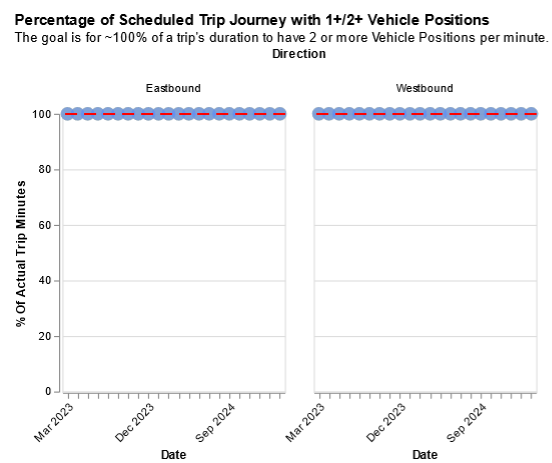

In [ ]:
def schd_trip_with_vps(df: pd.DataFrame) -> alt.Chart:
    chart = circle_chart(
        df=df,
        x_col="",
        y_col="",
        color_col="",
        color_scheme=["TBD"],
    )

    chart = chart.facet(
        column=alt.Column(
            "Direction:N",
        )
    )

    chart = configure_chart(
        chart, width=400, height=250, title="title", subtitle="subtitle"
    )
    return chart

## One large function - 13 charts in total excluding the dividers.


In [ ]:
def route_dropdown(df: pd.DataFrame):
    # Chart 1 and 2: I need one text chart for each direction
    text_chart = text_table(df, direction)
    # Chart 3 for average scheduled minutes per route, quarterly
    avg_scheduled_minutes_chart = avg_scheduled_minutes_chart(df)
    # Charts 4 and 5, need one chart for each direction, monthly
    timeliness_chart = timeliness_chart(df)
    # Charts 6 and 7, need one chart for each direction, monthly
    headway_chart = headway_chart(df)
    # Charts 8 and 9, need one chart for each direction, quarterly
    total_scheduled_trips_chart = total_scheduled_trips_chart(df)
    # Chart 10, monthly
    speed_chart = speed_chart(df)
    # Chart 11, quarterly
    vp_per_minute_chart = vp_per_minute_chart(df)
    # Chart 12, quarterly
    schd_trip_with_vps = schd_trip_with_vps(df)
    # Chart 13, quarterly
    spatial_accuracy_chart = spatial_accuracy_chart(df)

    # Concat
    # Also need to add some of the divider charts later
    charts_list = ["chart1", "chart2"]
    chart = alt.vconcat(*chart_list)

    return chart